In [1]:
import requests
import csv
import re
import numpy as np
import pandas as pd
from scipy import stats
import datetime
from time import time
import Quandl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import tickers

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import RandomizedPCA 

from sklearn.preprocessing import PolynomialFeatures
 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor 
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.grid_search import GridSearchCV

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

---

In [2]:
download = False

print len(tickers.tickers), "tickers"

if download == True:
    # download data
    for ticker in tickers.tickers:
        stock_df = Quandl.get("YAHOO/{}".format(ticker), authtoken='DVhizWXNTePyzzy1eHWR')
        stock_df.to_csv("quandl_data/{}.csv".format(ticker), index=False)

32 tickers


---

In [3]:
def modify_columns(ticker, normalize):
    df = pd.read_csv("quandl_data/{}.csv".format(ticker))
    df = df.drop('Adjusted Close', axis=1)
    
    df['50dravg'] = pd.rolling_mean(df['Close'], window=50)
    df['200dravg'] = pd.rolling_mean(df['Close'], window=200)

    if normalize == True:
        temp_df = df['Volume']
        df = df.drop('Volume', axis=1)
        df = df.std(axis=1, ddof=0)
        
        df['mean'] = df.mean(axis=1)
        df['std'] = std_df

        df['Open'] = (df['Open'] - df['mean']) / df['std']
        df['High'] = (df['High'] - df['mean']) / df['std']
        df['Low'] = (df['Low'] - df['mean']) / df['std']
        df['Close'] = (df['Close'] - df['mean']) / df['std']
        
        df['50dravg'] = (df['50dravg'] - df['mean']) / df['std']
        df['200dravg'] = (df['200dravg'] - df['mean']) / df['std']

        df = df.drop(['mean', 'std'], axis=1)

        df['Volume'] = temp_df

    df['OC%'] = (df['Close'] / df['Open']) - 1
    df['HL%'] = (df['High'] / df['Low']) - 1

    df['label'] = df['OC%'].shift(-1)
    
    return df #df.loc[1000:]

---

In [4]:
normalize = False

scale_volume = False

binarize = True

# import data
stock_df = pd.DataFrame()
for ticker in tickers.tickers:
    if stock_df.empty:
        stock_df = modify_columns(ticker, normalize)
    else:
        stock_df = stock_df.append(modify_columns(ticker, normalize))
        #stock_df = pd.concat([stock_df, modify_columns(ticker, normalize)])
        #stock_df = pd.concat([stock_df, modify_columns(ticker, normalize)], verify_integrity=True)
        
# scale volume
if scale_volume == True:     
    stock_df['Volume'] = (stock_df['Volume'] - stock_df['Volume'].min()) / (stock_df['Volume'].max() - stock_df['Volume'].min())
    
    # log volume
    #stock_df['Volume'] = stock_df['Volume'].map(lambda x: np.log(x))

#stock_df = stock_df.drop(['Open', 'High', 'Low', 'Close'], axis=1)

stock_df = stock_df.replace([np.inf, -np.inf], np.nan)
prediction_df = stock_df.copy()
stock_df = stock_df.dropna()

# binarize labels
if binarize == True:
    stock_df['label'] = stock_df['label'].map(lambda x: 1 if x >= 0.05 else 0)

print stock_df.shape
stock_df.tail()

(104714, 10)


,Open,High,Low,Close,Volume,50dravg,200dravg,OC%,HL%,label
813,8.23,8.48,8.10,8.13,207100,8.5674,7.01590,-0.012151,0.046914,0
814,8.13,8.26,7.77,7.81,294600,8.5800,7.02790,-0.039360,0.063063,0
815,7.82,7.85,7.13,7.55,529700,8.5870,7.03685,-0.034527,0.100982,0
816,7.50,7.54,7.20,7.27,301100,8.5874,7.04200,-0.030667,0.047222,1
817,7.12,7.74,7.12,7.58,245600,8.5992,7.04825,0.064607,0.087079,0


In [5]:
stock_df.describe()

,Open,High,Low,Close,Volume,50dravg,200dravg,OC%,HL%,label
count,104714.000000,104714.000000,104714.000000,104714.000000,1.047140e+05,104714.000000,104714.000000,104714.000000,104714.000000,104714.000000
mean,7.283012,7.487771,7.060714,7.271420,5.324266e+05,7.269978,7.278219,-0.000276,0.069054,0.095068
std,11.555737,11.987762,11.095547,11.525830,2.295534e+06,11.240197,10.610181,0.057314,0.087658,0.293311
min,0.003003,0.003003,0.003003,0.003003,0.000000e+00,0.004985,0.008659,-0.900000,0.000000,0.000000
25%,1.870000,1.930000,1.800000,1.860000,4.400000e+03,1.903860,1.974890,-0.022621,0.031746,0.000000
50%,4.250000,4.390000,4.125000,4.250000,4.520000e+04,4.287600,4.429769,0.000000,0.051095,0.000000
75%,8.250000,8.456616,8.020000,8.240000,3.703000e+05,8.269100,8.357363,0.017751,0.082105,0.000000
max,320.750000,327.000000,305.187500,320.500000,1.878141e+08,244.954375,165.755703,2.714286,9.000000,1.000000


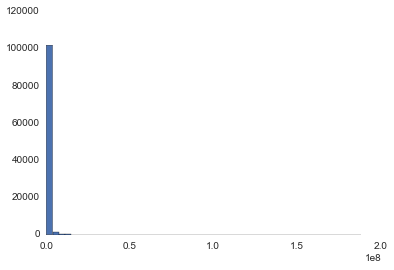

In [6]:
stock_df.Volume.hist(bins=50)

In [7]:
for i in xrange(len(stock_df.columns)):
    print i, stock_df.columns[i], stock_df.corr()['label'].values[i]

0 Open -0.0321878917803
1 High -0.0296240747405
2 Low -0.0346285810253
3 Close -0.0316624260364
4 Volume -0.000265422723524
5 50dravg -0.0279879123707
6 200dravg -0.0221498308317
7 OC% 0.0259721671047
8 HL% 0.117350632044
9 label 1.0


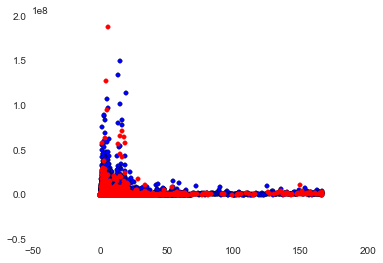

In [8]:
negative_df = stock_df[stock_df['label'] == 0]
positive_df = stock_df[stock_df['label'] == 1]

plt.scatter(negative_df['200dravg'], negative_df['Volume'])
plt.scatter(positive_df['200dravg'], positive_df['Volume'], color='r')
plt.show()

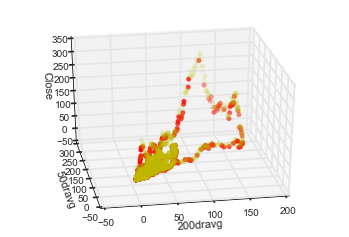

In [9]:
x, y, z = '200dravg', '50dravg', 'Close'

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(negative_df[x], negative_df[y], negative_df[z], alpha=0.1, color='y')
ax.scatter(positive_df[x], positive_df[y], positive_df[z], color='r')
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.view_init(azim=260)
plt.show()

In [10]:
y = stock_df['label'].values
stock_df = stock_df.drop('label', axis=1)
X = stock_df.values

print X.shape, y.shape

(104714, 9) (104714,)


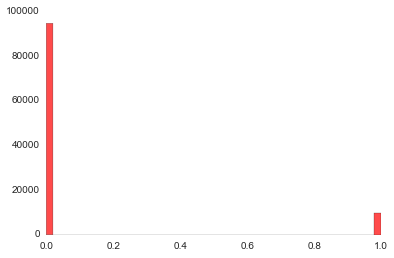

In [11]:
plt.hist(y, bins=50, alpha=0.7, color='r')
plt.show()

In [12]:
y_values = np.unique(y, return_counts=True)[0]
print y_values.shape, "\n"
print y_values

(2,) 

[0 1]


In [13]:
num_of_classes = np.unique(y, return_counts=True)[1]
print num_of_classes
print "percent 1: ", np.true_divide(num_of_classes[1],np.sum(num_of_classes))

[94759  9955]
percent 1:  0.0950684722196


In [14]:
classes_to_remove = []
for i in np.where(num_of_classes == 1)[0]:
    classes_to_remove.append(y_values[i])

print len(classes_to_remove)
print classes_to_remove[:5]
print classes_to_remove[-5:]

0
[]
[]


In [15]:
print "number of labels: ", np.unique(y, return_counts=True)[0].shape[0]

number of labels:  2


In [16]:
#for i in xrange(X.shape[1]):
#    plt.scatter(X[:,i], y)
#    plt.show()

In [17]:
#for i in xrange(X.shape[1]):
#    plt.hist(X[:,i])
#    plt.show()

---

In [18]:
skb = []
best_learner = []

#for k in xrange(1,X.shape[1]+1):
for k in xrange(8,9):
    
    print "\n", "#"*50, "\n"

    skb = SelectKBest(k=k)
    skb = skb.fit(X,y)
    new_X = skb.transform(X)

    t0 = time()

    clf_or_regr = "clf"
    pca = False

    ############################################################################

    if clf_or_regr == "regr":
        # add bias
        new_X = np.hstack((new_X, np.ones((new_X.shape[0], 1))))

        # single-class removal
        rows_to_remove = []
        for i in xrange(len(y)):
            if y[i] in classes_to_remove:
                rows_to_remove.append(i)

        new_X = np.delete(new_X, rows_to_remove, axis=0)
        y = np.delete(y, rows_to_remove)

    ############################################################################

    learner = []

    pipeline = []

    ############################################################################

    if clf_or_regr == "clf":
        #learner = GaussianNB()
        learner = DecisionTreeClassifier()
        #learner = RandomForestClassifier()
        #learner = SVC()
        #learner = LogisticRegression()

    if clf_or_regr == "regr":
        learner = LinearRegression()
        #learner = Ridge()
        #learner = Lasso()
        #learner = BayesianRidge()
        #learner = SGDRegressor()
        #learner = SVR()
        #learner = DecisionTreeRegressor()
        #learner = GradientBoostingRegressor()

    ############################################################################

    if pca == False:
        pipeline = make_pipeline(learner)
    elif pca == True:
        pipeline = make_pipeline(RandomizedPCA(), learner)

    # cross validation    
    cv = StratifiedShuffleSplit(y, test_size=0.2, random_state=42)

    # tune parameters
    params = dict()

    # for PCA
    if pca == True:
        #params['randomizedpca__iterated_power'] = [1, 2, 3]
        #params['randomizedpca__n_components'] = [2, 4, 6, 8, 10]
        params['randomizedpca__random_state'] = [42]
        #params['randomizedpca__whiten'] = [True, False]

    ############################################################################

    if clf_or_regr == "clf":
        if str(learner)[0] == 'X':
            params['decisiontreeclassifier__criterion'] = ['gini', 'entropy']
            params['decisiontreeclassifier__max_features'] = ['auto', 'sqrt', 'log2', None]
            params['decisiontreeclassifier__class_weight'] = ['auto', None]
            params['decisiontreeclassifier__random_state'] = [42]

        if str(learner)[0] == 'S':
            # [2**x for x in np.arange(-15, 15+1, 3)]
            params['svc__C'] = np.logspace(-2, 10, 13)
            params['svc__gamma'] = np.logspace(-9, 3, 13)
            params['svc__random_state'] = [42]

    ############################################################################        

    grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs=1, cv=cv)

    grid_search.fit(new_X, y)

    best_learner = grid_search.best_estimator_
    print best_learner
    print "\nscore: ", grid_search.best_score_

    best_learner = best_learner.fit(new_X,y)
    y_pred = best_learner.predict(new_X)

    ############################################################################

    if clf_or_regr == "clf":
        print "\nconfusion matrix:\n", "     FALSE   TRUE\n", "FALSE", confusion_matrix(y, y_pred)[0], "\nTRUE ", confusion_matrix(y, y_pred)[1]
        print "\n", classification_report(y, y_pred)

    print "\nprice data normalized:", normalize
    print "\nvolume scaled:", scale_volume
    print "\nbinarized:", binarize
    print "\nk =", k
    print "\nPCA:", pca
    print "\nminutes for learner to run:", round((time()-t0)/60.0, 3)
    print

    if k == 1:
        for i in xrange(len(stock_df.columns)):
            print stock_df.columns[i], np.round(skb.scores_[i], 2)


################################################## 

Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'))])

score:  0.830329943179

confusion matrix:
     FALSE   TRUE
FALSE [94758     1] 
TRUE  [   4 9951]

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     94759
          1       1.00      1.00      1.00      9955

avg / total       1.00      1.00      1.00    104714


price data normalized: False

volume scaled: False

binarized: True

k = 8

PCA: False

minutes for learner to run: 0.398



---

In [19]:
#X_df = pd.DataFrame(X[:,:4])
#X_df = pd.DataFrame(X)
#X_df['labels'] = y
#sns.pairplot(X_df, hue='labels')
#plt.show()

In [20]:
#plt.hist(y, color='b', alpha=0.7)
#plt.hist(y_pred, color='y', alpha=0.7)
#plt.show()

In [21]:
#plt.scatter(np.arange(y.shape[0]), y, color='b', alpha=0.7)
#plt.scatter(np.arange(y_pred.shape[0]), y_pred, color='y', alpha=0.7)
#plt.show()

In [22]:
#y_pred - y

In [23]:
#np.sum(y)

In [24]:
#error_count = 0
#for i in xrange(len(y)):
#    if y_pred[i] != y[i]:
#        error_count += 1
#        
#print error_count, " / ", len(y) 

---

In [25]:
prediction_df[prediction_df['label'].apply(np.isnan) == True].shape

(32, 10)

In [26]:
prediction_X = prediction_df[prediction_df['label'].apply(np.isnan) == True].drop('label', axis=1).values
print prediction_X.shape, "\n"
prediction_X = skb.transform(prediction_X)
y_pred = best_learner.predict(prediction_X)

for i in xrange(len(tickers.tickers)):
    print i, tickers.tickers[i], y_pred[i]

(32, 9) 

0 ABIO 0
1 ACOR 0
2 ADMA 0
3 AERI 0
4 AFFX 0
5 AGEN 0
6 APPY 0
7 ARDM 0
8 ARIA 0
9 ARNA 0
10 ARWR 0
11 AXDX 0
12 AXGN 0
13 BOTA 0
14 CBLI 0
15 CPRX 0
16 DARA 0
17 ECYT 0
18 EXAS 0
19 HALO 1
20 IDRA 0
21 INO 0
22 LPCN 0
23 MEIP 0
24 MNKD 0
25 OREX 0
26 PGNX 0
27 QLTI 0
28 RMTI 0
29 SGYP 0
30 THLD 0
31 TNXP 0


In [27]:
'''
new_X = stock_df.values
new_pred = learner.predict(new_X)
for i in xrange(len(tickers)):
    print "[{}]".format(i), tickers[i], new_pred[i]
'''

'\nnew_X = stock_df.values\nnew_pred = learner.predict(new_X)\nfor i in xrange(len(tickers)):\n    print "[{}]".format(i), tickers[i], new_pred[i]\n'

In [28]:
# http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_versus_svm_iris.html